# Text, image and audio embeddings principles using Azure Open AI (for text) Azure Computer Vision (for images) and PANNS (for audio)

<img src="embed.gif">

In [1]:
# %pip install datasets

In [2]:
# %pip install librosa

In [3]:
# %pip install panns_inference

In [4]:
import emoji
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import openai
import os
import pandas as pd
import pytz
import requests
import seaborn as sns
import sys

from datetime import datetime
from datasets import load_dataset
from dotenv import load_dotenv
from IPython.display import Audio, display
from itertools import combinations
from openai.embeddings_utils import get_embedding, cosine_similarity
from panns_inference import AudioTagging
from PIL import Image

In [5]:
local_tz = pytz.timezone(requests.get("https://ipinfo.io").json()["timezone"])
print("Local time:", datetime.now(local_tz).strftime("%d-%b-%Y %H:%M:%S"))

Local time: 05-Sep-2023 09:30:03


In [6]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

In [7]:
load_dotenv("azure.env")

# Get Azure Open AI credentials
openai.api_type: str = "azure"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE")
openai.api_version = os.getenv("OPENAI_API_VERSION")

# Get Azure Computer Vision credentials
azure_cv_endpoint = os.getenv("azure_cv_endpoint")
azure_cv_key = os.getenv("azure_cv_key")

## 1. Text embeddings with Azure Open AI

In [8]:
print("Open AI version:", openai.__version__)

Open AI version: 0.27.9


In [9]:
# Azure Open AI embeddings model to use
embeddings_engine = "text-embedding-ada-002"

In [10]:
def openai_text_embeddings(text):
    """
    Generating embeddings from text using Azure Open AI
    """
    embeddings = openai.Embedding.create(
        input=text,
        deployment_id=embeddings_engine,
    )
    embeddings = embeddings["data"][0]["embedding"]

    return embeddings

In [11]:
def text_comparison(vector1, vector2):
    """
    Cosine similarity value between two embedded vectors
    """
    if len(vector1) != len(vector2):
        print("[Error] Vectors do not have the same size")
        return None

    dot_product = sum(x * y for x, y in zip(vector1, vector2))
    magnitude1 = math.sqrt(sum(x * x for x in vector1))
    magnitude2 = math.sqrt(sum(x * x for x in vector2))
    cosine_similarity = round(dot_product / (magnitude1 * magnitude2), 15)

    # Or we can use directly the cosine_similarity function from Open AI

    if cosine_similarity == 1:
        decision = "identical"
        color_code = "\033[1;31;34m"
        emoticon = emoji.emojize(":red_heart:")

    elif cosine_similarity >= 0.8:
        decision = "similar semantic"
        color_code = "\033[1;31;32m"
        emoticon = emoji.emojize(":thumbs_up:")

    else:
        decision = "different"
        color_code = "\033[1;31;91m"
        emoticon = emoji.emojize(":fire:")

    print(
        f"{emoticon} {color_code}{decision.upper()} text (cosine similarity = {cosine_similarity})"
    )
    print("\033[0m")

<img src = "cosine.png">

In [12]:
text = "Hello. Good morning!"

In [13]:
emb = openai_text_embeddings(text)

In [14]:
emb[:10]

[-0.010011719539761543,
 -0.004450335167348385,
 -0.010907924734055996,
 -0.019716519862413406,
 -0.00956361647695303,
 0.011411272920668125,
 -0.0061967079527676105,
 -0.0026517859660089016,
 -0.00823772419244051,
 0.005546038504689932]

In [15]:
print("Text vector embedding size =", len(emb))

Text vector embedding size = 1536


In [16]:
%%javascript Python
OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [17]:
text_list = [
    "My name is James Bond",
    "Ian Fleming",
    "Sir Thomas Sean Connery",
    "Le Bossu de Notre-Dame",
    "Victor Hugo",
    "Les misérables",
    "Guitar",
    "Musical instrument",
    "Gibson Les Paul",
]

text_list

['My name is James Bond',
 'Ian Fleming',
 'Sir Thomas Sean Connery',
 'Le Bossu de Notre-Dame',
 'Victor Hugo',
 'Les misérables',
 'Guitar',
 'Musical instrument',
 'Gibson Les Paul']

In [18]:
combs = list(combinations(text_list, 2))

for idx, (text1, text2) in enumerate(combs, start=1):
    print(f"{idx} Comparing", text1, "vs", text2)
    emb1 = openai_text_embeddings(text1)
    emb2 = openai_text_embeddings(text2)
    text_comparison(emb1, emb2)

1 Comparing My name is James Bond vs Ian Fleming
👍 SIMILAR SEMANTIC text (cosine similarity = 0.827552306100126)

2 Comparing My name is James Bond vs Sir Thomas Sean Connery
👍 SIMILAR SEMANTIC text (cosine similarity = 0.845319746575366)

3 Comparing My name is James Bond vs Le Bossu de Notre-Dame
🔥 DIFFERENT text (cosine similarity = 0.746392690554922)

4 Comparing My name is James Bond vs Victor Hugo
🔥 DIFFERENT text (cosine similarity = 0.756824851161782)

5 Comparing My name is James Bond vs Les misérables
🔥 DIFFERENT text (cosine similarity = 0.737250523947909)

6 Comparing My name is James Bond vs Guitar
🔥 DIFFERENT text (cosine similarity = 0.756886593098276)

7 Comparing My name is James Bond vs Musical instrument
🔥 DIFFERENT text (cosine similarity = 0.746506644326878)

8 Comparing My name is James Bond vs Gibson Les Paul
🔥 DIFFERENT text (cosine similarity = 0.755756617567427)

9 Comparing Ian Fleming vs Sir Thomas Sean Connery
👍 SIMILAR SEMANTIC text (cosine similarity = 0.

### Of course cosine between the same vector is = 1

In [19]:
text = "Azure Open AI is great"

emb = openai_text_embeddings(text)
text_comparison(emb, emb)

❤️ IDENTICAL text (cosine similarity = 1.0)



## 2. Image Embeddings with Azure Computer Vision 4 (Florence)

In [20]:
version = "?api-version=2023-02-01-preview&modelVersion=latest"

vec_img_url = (
    azure_cv_endpoint + "/computervision/retrieval:vectorizeImage" + version
)  # For doing the image vectorization

vec_txt_url = (
    azure_cv_endpoint + "/computervision/retrieval:vectorizeText" + version
)  # For the prompt vectorization

headers = {
    "Content-type": "application/json",
    "Ocp-Apim-Subscription-Key": azure_cv_key,
}

In [21]:
def image_embedding(imageurl):
    """
    Embedding image using Azure Computer Vision 4
    """
    image = {"url": imageurl}
    r = requests.post(vec_img_url, data=json.dumps(image), headers=headers)
    image_emb = r.json()["vector"]

    return image_emb

In [22]:
def text_embedding(prompt):
    """
    Embedding text uusing Azure Computer Vision 4
    """
    prompt = {"text": prompt}
    r = requests.post(vec_txt_url, data=json.dumps(prompt), headers=headers)
    text_emb = r.json()["vector"]

    return text_emb

In [23]:
def similarity_results(image_emb, prompts):
    """ "
    Get similarity results
    """
    simil_values_list = [
        cosine_similarity(image_emb, text_embedding(prompt)) for prompt in prompts
    ]
    sorted_results = sorted(
        zip(prompts, simil_values_list), key=lambda x: x[1], reverse=True
    )

    df = pd.DataFrame(columns=["prompt", "cosine_similarity"])
    for idx, (prompt, simil_val) in enumerate(sorted_results):
        df.loc[idx, "prompt"] = prompt
        df.loc[idx, "cosine_similarity"] = simil_val

    df["cosine_similarity"] = df.cosine_similarity.astype(float)

    return df

### Text and image

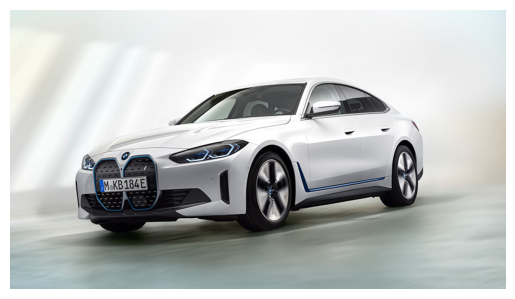

In [24]:
url = "https://github.com/retkowsky/images/blob/master/i4.jpg?raw=true"
image_emb = image_embedding(url)

plt.imshow(Image.open(requests.get(url, stream=True).raw))
plt.axis("off")
plt.show()

In [25]:
text1 = text_embedding("a dog")
cosine_similarity(image_emb, text1)

0.11466790040215122

In [26]:
print("Text vector embedding size =", len(text1))

Text vector embedding size = 1024


In [27]:
text2 = text_embedding("a BMW i4 white car")
cosine_similarity(image_emb, text2)

0.42900749036703767

### With multiple prompts

In [28]:
prompts = [
    "bird",
    "a truck",
    "a car",
    "a blue car",
    "a white car",
    "a BMW white car",
    "a BMW i4 white car",
    "a tesla car",
    "a mercedes car",
    "a man",
    "a ford car",
]

In [29]:
df = similarity_results(image_emb, prompts)

cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm)

,prompt,cosine_similarity
0,a BMW i4 white car,0.429007
1,a BMW white car,0.348609
2,a white car,0.311181
3,a blue car,0.271805
4,a car,0.268165
5,a tesla car,0.226975
6,a ford car,0.225841
7,a mercedes car,0.221624
8,a truck,0.159409
9,a man,0.151200


## Image and image

In [30]:
def images_comparison(vector1, vector2):
    """
    Get cosine similarity value between two embedded vectors
    """
    cos_similarity = round(cosine_similarity(vector1, vector2), 10)

    if cos_similarity == 1:
        decision = "identical"
        color_code = "\033[1;31;34m"
        emoticon = emoji.emojize(":red_heart:")
    elif cos_similarity >= 0.8:
        decision = "similar"
        color_code = "\033[1;31;32m"
        emoticon = emoji.emojize(":thumbs_up:")
    else:
        decision = "different"
        color_code = "\033[1;31;91m"
        emoticon = emoji.emojize(":fire:")

    print(
        f"{emoticon} {color_code}{decision.upper()} images (cosine similarity = {cos_similarity})"
    )

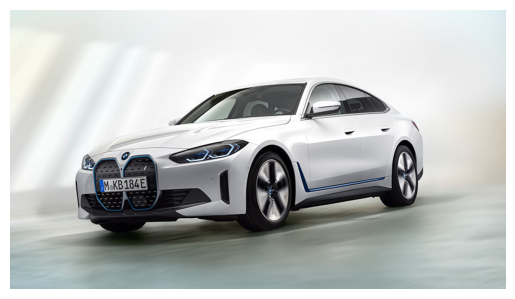

In [31]:
url1 = "https://github.com/retkowsky/images/blob/master/i4.jpg?raw=true"
car1_emb = image_embedding(url1)

plt.imshow(Image.open(requests.get(url1, stream=True).raw))
plt.axis("off")
plt.show()

In [32]:
print("Image vector embedding size =", len(car1_emb))

Image vector embedding size = 1024


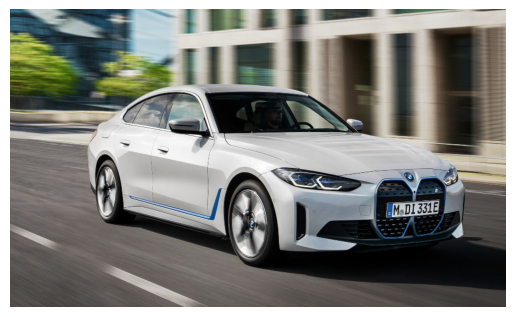

In [33]:
url2 = "https://github.com/retkowsky/images/blob/master/i4_2.jpg?raw=true"
car2_emb = image_embedding(url2)

plt.imshow(Image.open(requests.get(url2, stream=True).raw))
plt.axis("off")
plt.show()

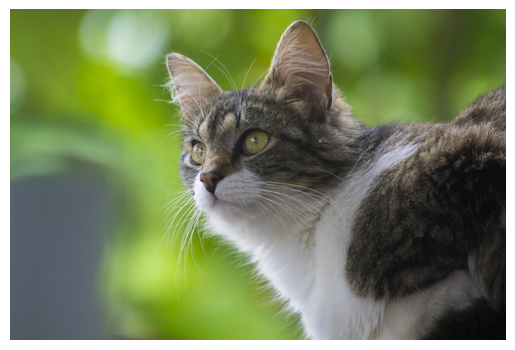

In [34]:
url3 = "https://github.com/retkowsky/images/blob/master/cat.jpg?raw=true"
cat_emb = image_embedding(url3)

plt.imshow(Image.open(requests.get(url3, stream=True).raw))
plt.axis("off")
plt.show()

In [35]:
images_comparison(car1_emb, car1_emb)

❤️ IDENTICAL images (cosine similarity = 1.0)


In [36]:
images_comparison(car1_emb, car2_emb)

👍 SIMILAR images (cosine similarity = 0.9472660876)


In [37]:
images_comparison(car1_emb, cat_emb)

🔥 DIFFERENT images (cosine similarity = 0.3390264066)


In [38]:
images_comparison(car2_emb, cat_emb)

🔥 DIFFERENT images (cosine similarity = 0.3267457371)


## 3. Sound embeddings using panns_inference

In [39]:
sounds_dataset = load_dataset("ashraq/esc50", split="train")
sounds_dataset

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['filename', 'fold', 'target', 'category', 'esc10', 'src_file', 'take', 'audio'],
    num_rows: 2000
})

In [40]:
sounds_dataset[0]

{'filename': '1-100032-A-0.wav',
 'fold': 1,
 'target': 0,
 'category': 'dog',
 'esc10': True,
 'src_file': 100032,
 'take': 'A',
 'audio': {'path': None,
  'array': array([0., 0., 0., ..., 0., 0., 0.]),
  'sampling_rate': 44100}}

In [41]:
def get_sound_embedding(audio_numpy):
    """
    Get sound embedding from a numpy array audio file using panns_inference
    """
    _, emb = model.inference(audio_numpy[None, :])

    return emb

In [42]:
def play_audio(audio_numpy):
    """
    Playing a numpy audio file
    """
    audio_data = sounds_dataset[audio_numpy]
    filename = audio_data["filename"]
    category = audio_data["category"]
    audio_array = audio_data["audio"]["array"]

    print("Audio file:", filename)
    print("Category:", category)
    display(
        Audio(audio_array, rate=44100, autoplay=False)
    )  # All our files here have the same sr

    return audio_array

In [43]:
def amplitude(audio_array):
    """
    Amplitude plot of an audio array
    """
    plt.figure(figsize=(15, 5))
    sr = 44100
    time = np.linspace(0, len(audio_array) / sr, num=len(audio_array))
    plt.grid(True, color="gray", linestyle="--")
    plt.ylabel("Amplitude")
    plt.title("Amplitude Chart")
    plt.xlabel("Time in seconds")
    plt.plot(time, audio_array)

    plt.show()

Audio file: 3-152007-A-20.wav
Category: crying_baby


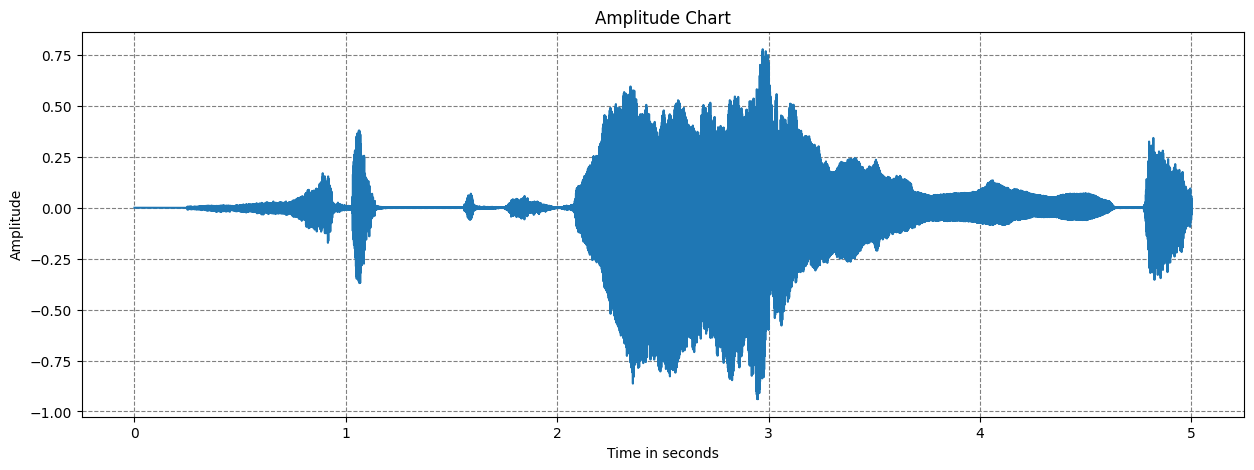

In [44]:
crying_baby1 = play_audio(1007)
amplitude(crying_baby1)

Audio file: 3-152007-B-20.wav
Category: crying_baby


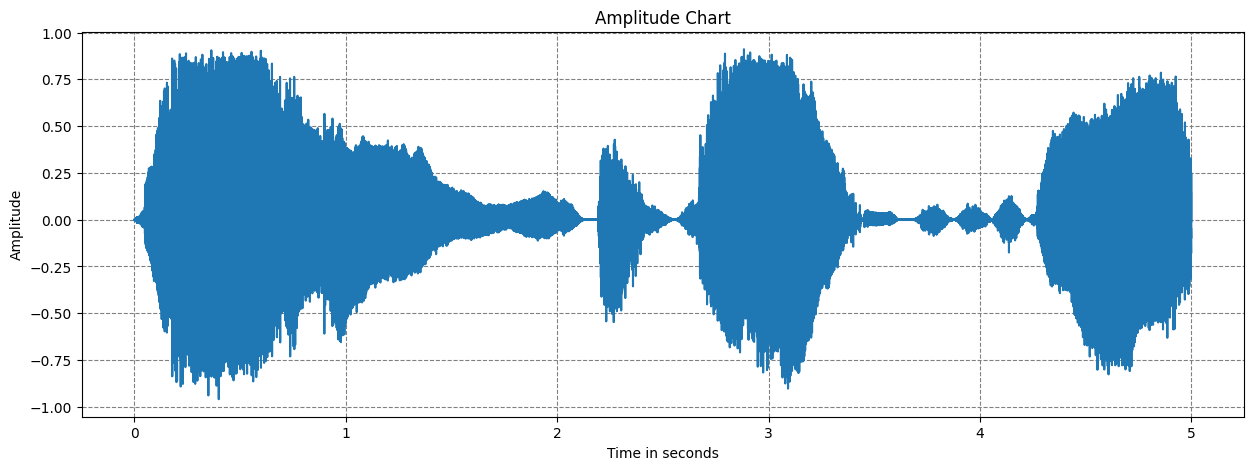

In [45]:
crying_baby2 = play_audio(1008)
amplitude(crying_baby2)

Audio file: 5-192191-A-19.wav
Category: thunderstorm


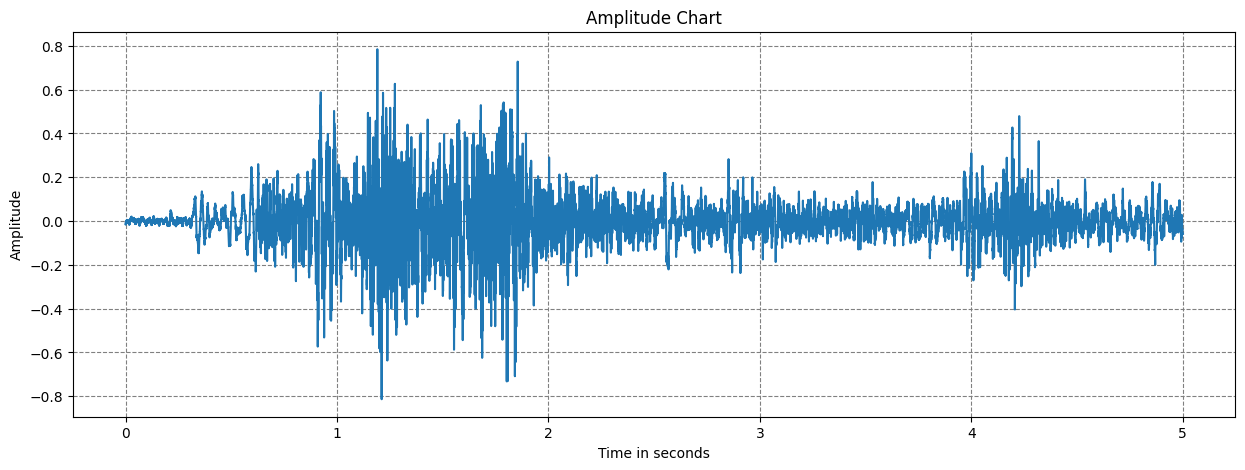

In [46]:
thunderstorm = play_audio(1700)
amplitude(thunderstorm)

In [47]:
model = AudioTagging(
    checkpoint_path=None,
    device="cpu",
)
# change device to cpu or gpu

Checkpoint path: /home/azureuser/panns_data/Cnn14_mAP=0.431.pth
Using CPU.


In [48]:
crying_baby1_emb = get_sound_embedding(crying_baby1)

In [49]:
print("Sound vector embedding size =", crying_baby1_emb.shape[1])

Sound vector embedding size = 2048


In [50]:
crying_baby2_emb = get_sound_embedding(crying_baby2)

In [51]:
thunder_emb = get_sound_embedding(thunderstorm)

In [52]:
def get_sound_cosine_similarity(vector1, vector2):
    """
    Get cosine similarity value between 2 vectors embeddings from audio files
    """
    vector1 = np.array(vector1.tolist()[0])
    vector2 = np.array(vector2.tolist()[0])
    cosine_similarity = np.dot(vector1, vector2) / (
        np.linalg.norm(vector1) * np.linalg.norm(vector2)
    )

    return cosine_similarity

In [53]:
def sounds_comparison(vector1, vector2):
    """
    Cosine Similarity analysis for sounds
    """
    cosine_similarity = round(get_sound_cosine_similarity(vector1, vector2), 10)

    if cosine_similarity == 1:
        decision = "identical"
        color_code = "\033[1;31;34m"
        emoticon = emoji.emojize(":red_heart:")
    elif cosine_similarity >= 0.8:
        decision = "similar"
        color_code = "\033[1;31;32m"
        emoticon = emoji.emojize(":thumbs_up:")
    else:
        decision = "different"
        color_code = "\033[1;31;91m"
        emoticon = emoji.emojize(":fire:")

    print(
        f"{emoticon} {color_code}{decision.upper()} sounds (cosine similarity = {cosine_similarity})"
    )

In [54]:
sounds_comparison(crying_baby1_emb, crying_baby1_emb)

❤️ IDENTICAL sounds (cosine similarity = 1.0)


In [55]:
sounds_comparison(crying_baby1_emb, crying_baby2_emb)

👍 SIMILAR sounds (cosine similarity = 0.8779551828)


In [56]:
sounds_comparison(thunder_emb, crying_baby1_emb)

🔥 DIFFERENT sounds (cosine similarity = 0.4245402464)


In [57]:
sounds_comparison(thunder_emb, crying_baby2_emb)

🔥 DIFFERENT sounds (cosine similarity = 0.4703236459)
